In [1]:
import logging

from utils import logging as lg


lg.set_logging(logging.ERROR)

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cmocean


tf.logging.set_verbosity(tf.logging.DEBUG)

import math

from utils import data_provider
from utils import experiment_artifact
from notebook_utils import plot
from model import s2_network, s3_network, provider as model_provider

from heatmap_tutorial import modules, utils
import matplotlib.gridspec as gridspec

plot.setup()


# Data Preparation

In [3]:
X_train, Y_train = data_provider.get_mnist('train', dir_path='../data/mnist')
X_test, Y_test = data_provider.get_mnist('test', dir_path='../data/mnist')

In [4]:
Y_test_in_number = np.sum(Y_test * np.arange(0, 10), axis=1)
print(Y_test.shape)
print(Y_test_in_number.shape)

(10000, 10)
(10000,)


In [5]:
X_train_2d = np.copy(X_train.reshape((-1,28,28)))
X_test_2d = np.copy(X_test.reshape((-1,28,28)))

In [6]:
x_from_tutorial, y_from_tutorial = utils.getMNISTsample(N=12,path='../data/mnist',seed=1234)
x_from_tutorial = x_from_tutorial.reshape(-1,28,28)

# Visualize Relevance

In [7]:
def get_test_data_in_class(label):
    if label is None:
        return X_test, Y_test
    selector = Y_test_in_number == label
    return X_test[selector, :], Y_test[selector]

def plot_digits(data, limit=200):
    plt.figure(figsize=(20,20))
    count = 1
    for i in range(limit):
        plt.subplot(10,20, count)
        plt.imshow(data[i,:].reshape(28,28))
        plt.xticks([])
        plt.yticks([])
        plt.title(i)
        count = count + 1
    plt.tight_layout()
    plt.show()

In [12]:
def plot_relevance_methods(model_path, 
                           data = x_from_tutorial, methods=['sensitivity', 'simple_taylor', 'lrp_deep_taylor']
                          ):
    model_obj = model_provider.load(model_path)

    total = data.shape[0]
    
    methods = [None] + methods
    total_methods = len(methods)
    
    fig = plt.figure(figsize=(20,2*total_methods))

    outer = gridspec.GridSpec(total_methods, 1)

    pred_heatmaps = dict()
    actual_methods = list(filter(lambda x: x, methods))
    for method in actual_methods:
        pred_heatmaps[method] = getattr(model_obj, 'rel_%s' % method)(data, debug=False)

    for i in range(total_methods):
        inner = gridspec.GridSpecFromSubplotSpec(1, total,
                        subplot_spec=outer[i], wspace=0.1, hspace=0.01)
   
        method = methods[i]
            
        for j in range(total):
            ax = plt.Subplot(fig, inner[j])
            if method is not None:
                heatmap = pred_heatmaps[method][1][j,:,:]
            else:
                heatmap = data[j,:]
                ax.set_title('Pred %d' % pred_heatmaps[actual_methods[0]][0][j])

            ax.imshow(heatmap, cmap="Reds")
            ax.set_xticks([])
            ax.set_yticks([])

            fig.add_subplot(ax)
        
        ax_outer = plt.Subplot(fig, outer[i])
        if method is not None:
            title = method
        else:
            title = 'data'
            
        ax_outer.set_title('\n%s\n' % title)

        ax_outer._frameon = False
        ax_outer.xaxis.set_visible(False)
        ax_outer.yaxis.set_visible(False)
        fig.add_subplot(ax_outer)

    plt.suptitle('Heatmaps from different explaination methods\n%s:%s\n%s (no. variables %d ) \n(opt %s, acc %.4f, keep_prob %.2f)' %
                         (
                          model_obj._.architecture_name,
                          model_obj._.architecture,
                          model_obj._.experiment_name,
                          model_obj.dag.no_variables(),
                          model_obj._.optimizer,
                          model_obj._.accuracy,
                          model_obj._.keep_prob
                         ), y = 1.1)
    
    plt.tight_layout()    

    plt.show()
# plot_relevance_methods(seq_4_s2_model)

In [13]:
x_cls_5, y_cls_5 = get_test_data_in_class(5)

In [14]:
x_cls_all, x_cls_all = get_test_data_in_class(None)

In [15]:
def rel_dist_deep_taylor(model_obj, data):
    
    _, heatmap = model_obj.lrp(data, debug=False)

    relevance_dist = np.sum(heatmap.transpose(2,1,0).reshape(model_obj._.seq_length,-1),axis=1)

    return relevance_dist, heatmap

model_obj = model_provider.load('../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22')
rel_dist_dt, heatmap = rel_dist_deep_taylor(model_obj, X_test)

INFO:tensorflow:Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


2017-11-30 16:30:54,184 | INFO : tf_logging.py(info 82) - Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


INFO:tensorflow:Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


2017-11-30 16:31:09,093 | INFO : tf_logging.py(info 82) - Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


INFO:tensorflow:Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


2017-11-30 16:31:14,788 | INFO : tf_logging.py(info 82) - Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


INFO:tensorflow:Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


2017-11-30 16:31:20,909 | INFO : tf_logging.py(info 82) - Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


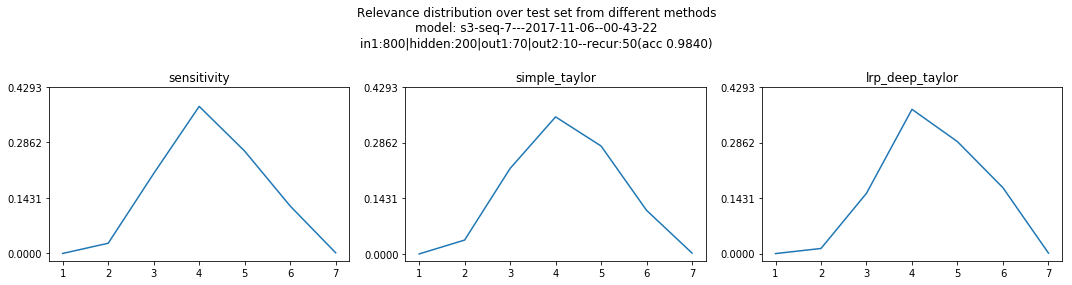

In [16]:
def plot_relevance_dist(model_path, data=X_test_2d, methods=['sensitivity', 'simple_taylor', 'lrp_deep_taylor']):
    model_obj = model_provider.load(model_path)
    no_seq = model_obj._.seq_length

    dist_dict = dict()
    max_rel = 0
    for m in methods:
        if m == None:
            heatmap = data
        else:
            _, heatmap = getattr(model_obj, 'rel_%s' % m)(data, debug=False)
            
        dist = np.sum(heatmap.transpose(2,1,0).reshape(model_obj._.seq_length,-1),axis=1)
        dist_dict[m] = dist / np.sum(dist)
        mv = np.max(dist_dict[m])
        if mv > max_rel:
            max_rel = mv
            
    plt.figure(figsize=(15,4))
    
    x_ticks = np.arange(no_seq) + 1
    y_ticks = np.linspace(0, max_rel+0.05, 4)
    for i, m in zip(range(1, len(methods)+1), methods):
        plt.subplot(1,len(methods),i)
        plt.plot(x_ticks, dist_dict[m])
        if i == 1 or True:
            plt.yticks(y_ticks)
            plt.xticks(x_ticks)
        else:
#             plt.yticks([])
#             plt.xticks([])
            pass
    
        plt.title(m)
    plt.suptitle('Relevance distribution over test set from different methods\nmodel: %s\n%s(acc %.4f)' %
         (
             model_obj._.experiment_name,
             model_obj._.architecture,
             model_obj._.accuracy,
         ),
        )
    plt.tight_layout()
    plt.subplots_adjust(top=0.7)

    plt.show()
plot_relevance_dist('../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22')

INFO:tensorflow:Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


2017-11-30 16:31:35,803 | INFO : tf_logging.py(info 82) - Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


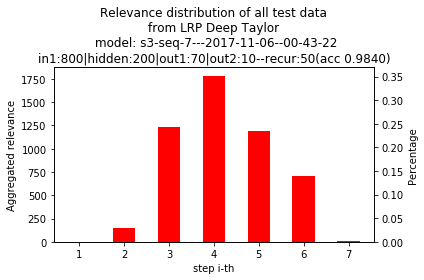

In [17]:
def plot_lrp_dt_relevance_distribution(model_path, label=None):
#     plt.figure(figsize=(8,5))
    fig, ax1 = plt.subplots()
    bar_width= 0.5
    model_obj = model_provider.load(model_path)

    x, _ = get_test_data_in_class(label)

    x_ticks = np.arange(model_obj._.seq_length) + 1

    rel_dist_dt, _ = rel_dist_deep_taylor(model_obj, x)

    ax1.bar(x_ticks, rel_dist_dt, bar_width, color='red')
    ax1.set_xticks(x_ticks)
    ax1.set_xlabel('step i-th')
    
    data_desc = 'all test data'
    if label is not None:
        data_desc = 'class %d' % label
    ax1.set_ylabel('Aggregated relevance')
    ax1.set_title('Relevance distribution of %s\nfrom LRP Deep Taylor\n model: %s\n%s(acc %.4f)' %
             (
                 data_desc,
                 model_obj._.experiment_name,
                 model_obj._.architecture,
                 model_obj._.accuracy,
             ),
            )

    ax2 = ax1.twinx()
    relative_dist = rel_dist_dt / np.sum(rel_dist_dt)
    ax2.bar(x_ticks, relative_dist, bar_width, color='r')
    ax2.set_ylabel('Percentage')
    ax2.tick_params('y')

    fig.tight_layout()
    plt.show()

plot_lrp_dt_relevance_distribution('../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22')

In [18]:
def plot_lrp_relevance_dist_all(model_path):
    fig = plt.figure(figsize=(15,7.5))
    
    rel_dists = []

    model_obj = model_provider.load(model_path)
    for i in [None] + list(range(0,10)):
        x, _ = get_test_data_in_class(i)
        rel_dist_dt, _ = rel_dist_deep_taylor(model_obj, x)
        rel_dists.append(rel_dist_dt)

        
        
    labels = ['All Test Data'] + list(map(lambda x: 'Class %d' % x, range(0,10)))
    x_ticks = np.arange(model_obj._.seq_length) + 1
    
    plt.suptitle('Relevance distribution from LRP Deep Taylor\n model: %s\n%s(acc %.4f)' %
             (
                 model_obj._.experiment_name,
                 model_obj._.architecture,
                 model_obj._.accuracy,
             ),
            )
    
    for i, r in zip(range(len(rel_dists)), rel_dists):
        if i == 0:
            ax = plt.subplot2grid((4, 3), (0, 0), rowspan=2)
        else:
            row_id = int(i/3)
            col_id = i%3
            if row_id >= 1:
                col_id = col_id + 1
                if col_id >= 3:
                    row_id = row_id+1
                    col_id = (col_id)%3
            ax = plt.subplot2grid((4, 3), (row_id, col_id))
    #         print('%d and (%d,%d)' % (i, row_id, col_id))
    # ax0.plot()
        rel_dist = rel_dists[i]

        def plot_bar_chart(axis, data):
            axis.bar(x_ticks, data, 0.5, color='r')
            axis.set_xticks(x_ticks)
        plot_bar_chart(ax, rel_dist)

        ax2 = ax.twinx()

        if i == 0:
            ax.set_ylabel('Aggregated relevance')
            ax.set_xlabel('Step $i$-th')
            ax2.set_ylabel('Percentage')

        relative_dist = rel_dist / np.sum(rel_dist)
        plot_bar_chart(ax2, relative_dist)

        ax.set_title(labels[i])

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
    

In [19]:
def plot_weight_proportion(model_path, show_title=False):
    model_obj = model_provider.load(model_path)

    layers = sorted(model_obj.dag.layers.keys())
    total_layers = len(layers)
    idv_size = 4
    plt.figure(figsize=(idv_size*total_layers, idv_size))

    with model_obj.get_session() as sess:
        for i, l in zip(range(total_layers), layers):
            w = model_obj.dag.layers[l].W.eval(session=sess)
            total = (w.shape[0]*w.shape[1])
            w_pos = np.sum(w>0)  / total
            w_neg = np.sum(w<=0)  / total

            plt.subplot(1,total_layers, i+1)
            plt.title('Layer %s' % l)
            plt.pie([w_pos,w_neg], labels=['$W^+$','$W^-_0$'],
                    startangle=90, colors=['r','#EFEFEF'], autopct='%1.0f%%')
    if show_title:
        plt.suptitle('Positive/Negative Weight Proportion in each layer\n model: %s\n%s(acc %.4f)' %
                 (
                     model_obj._.experiment_name,
                     model_obj._.architecture,
                     model_obj._.accuracy,
                 ),
                )
    plt.tight_layout()
    if show_title:
        plt.subplots_adjust(top=0.75)

    plt.show()

## Seq 4

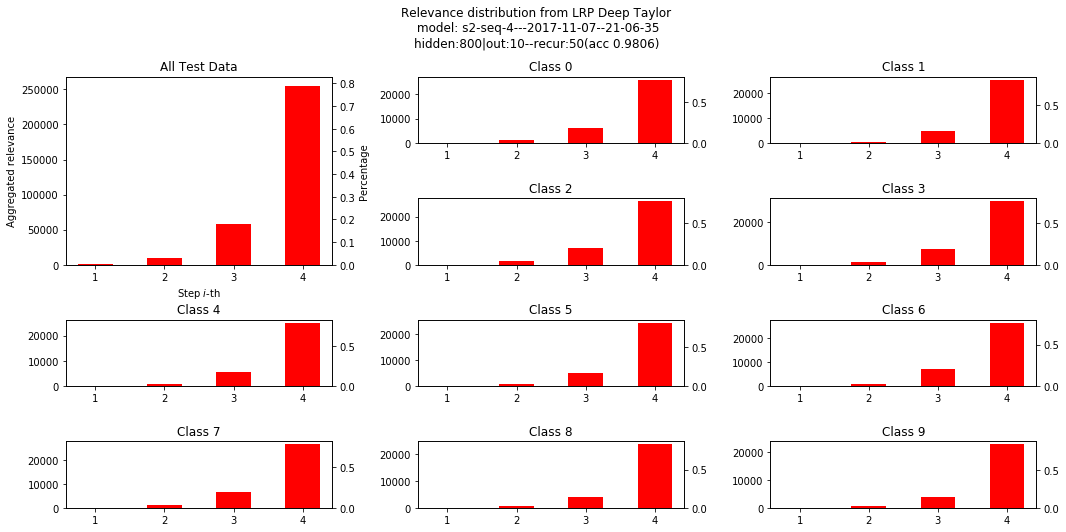

In [66]:
seq_4_s2_model='../experiment-results/sprint-6/s2-seq-4---2017-11-07--21-06-35'
plot_lrp_relevance_dist_all(seq_4_s2_model)

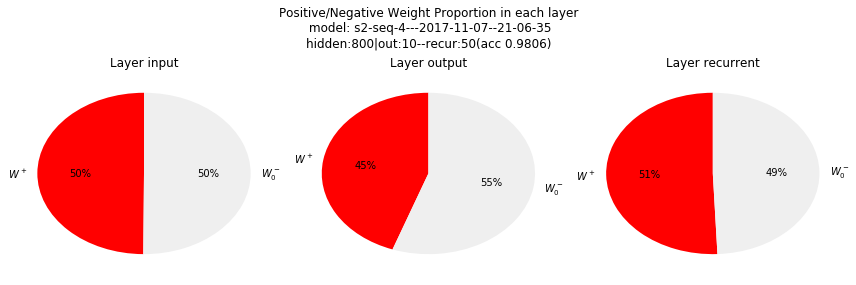

In [67]:
plot_weight_proportion(seq_4_s2_model, show_title=True)

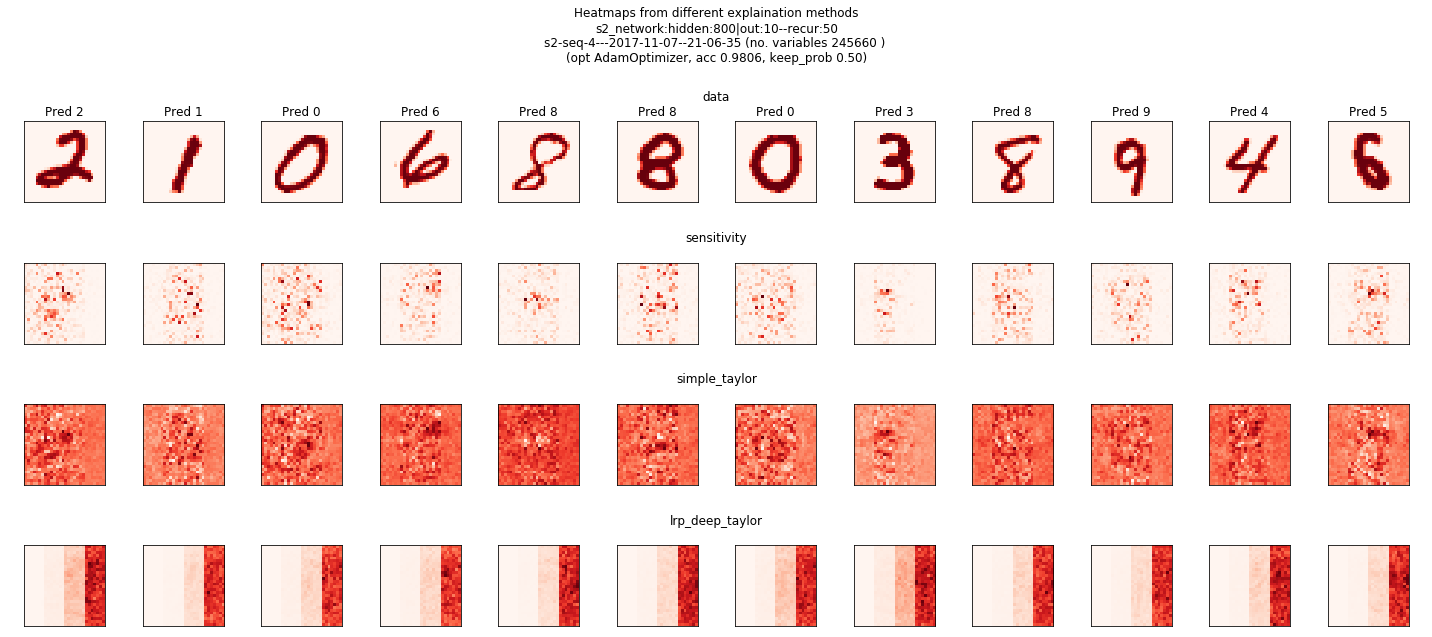

In [72]:
plot_relevance_methods(seq_4_s2_model)

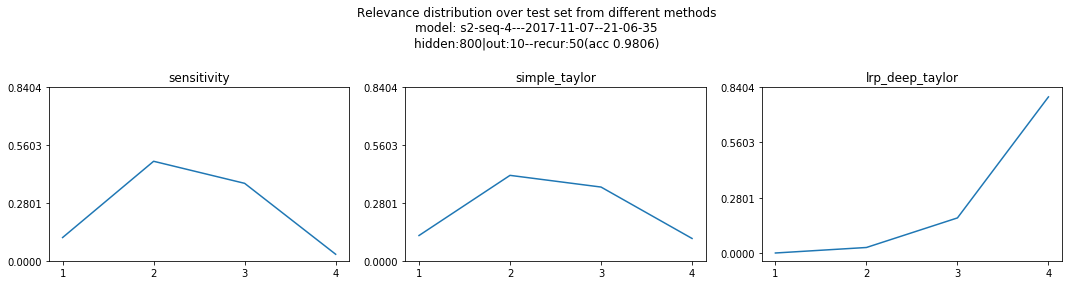

In [69]:
plot_relevance_dist(seq_4_s2_model)

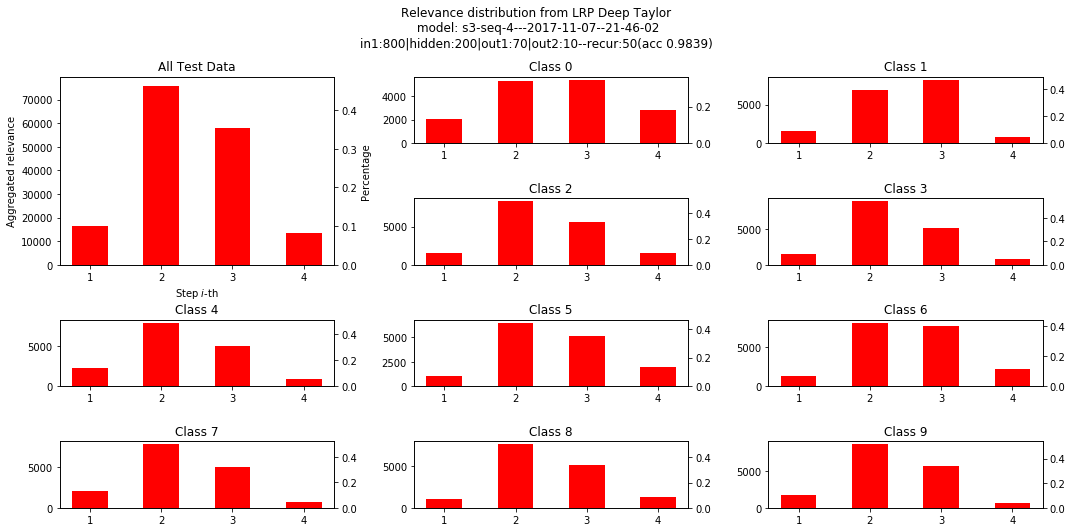

In [73]:
seq_4_s3_model='../experiment-results/sprint-6/s3-seq-4---2017-11-07--21-46-02'
plot_lrp_relevance_dist_all(seq_4_s3_model)

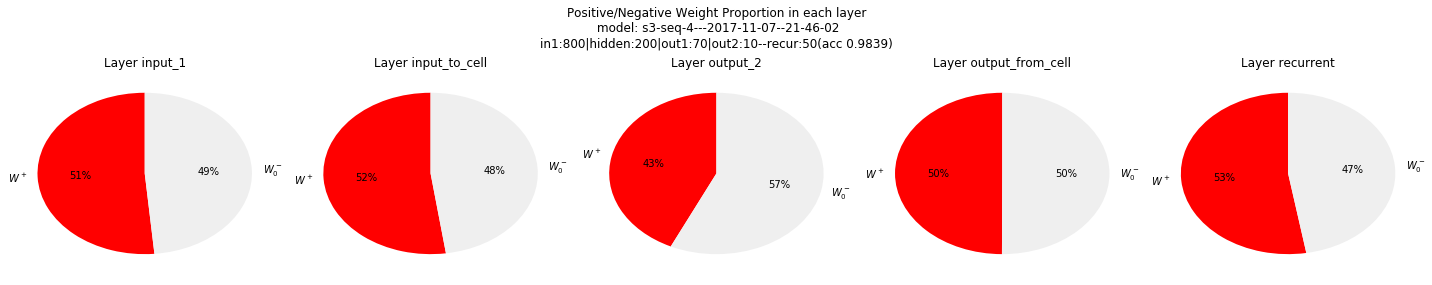

In [74]:
plot_weight_proportion(seq_4_s3_model, show_title=True)

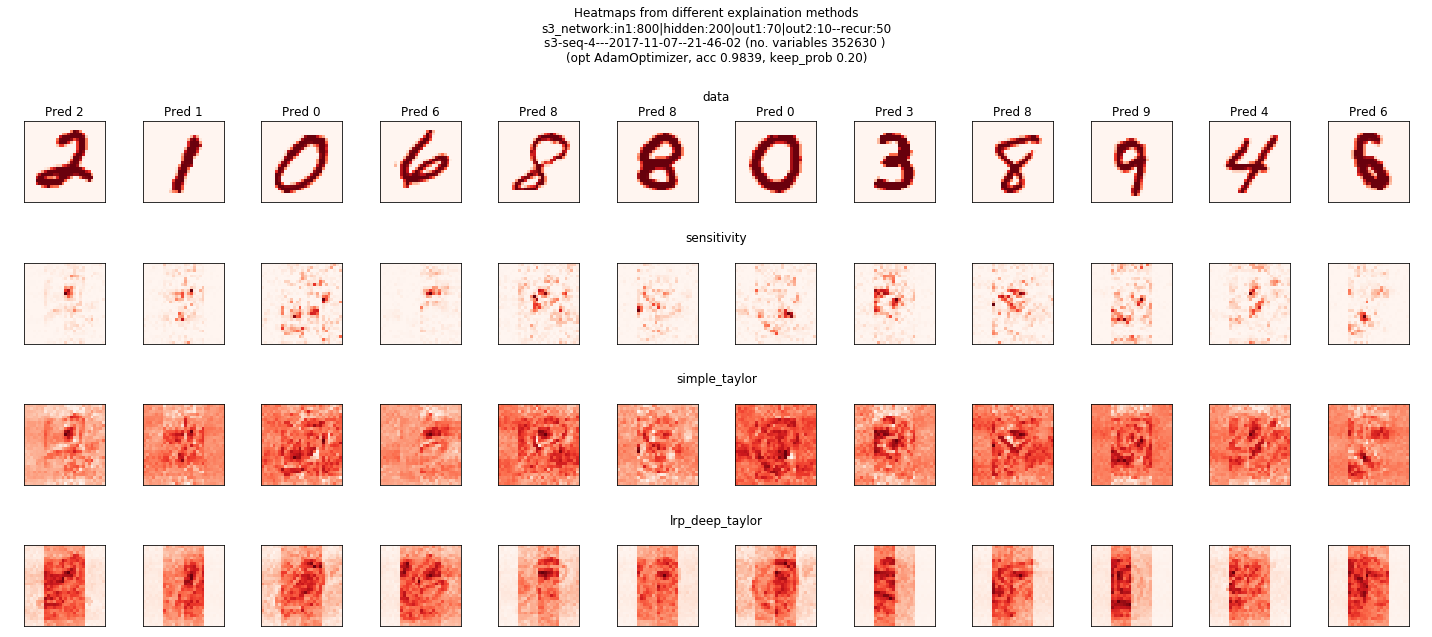

In [75]:
plot_relevance_methods(seq_4_s3_model)

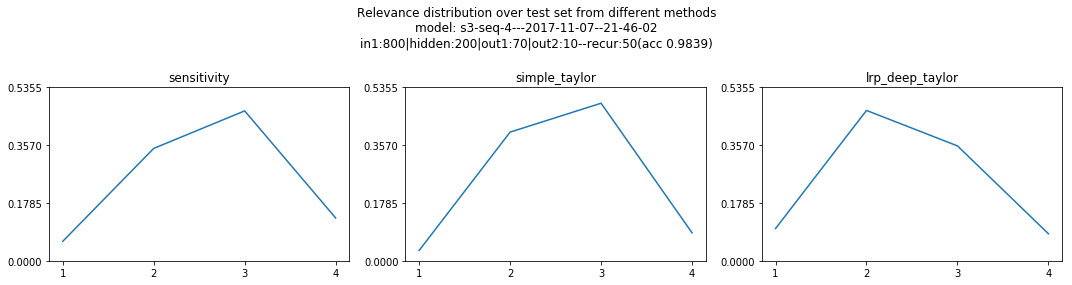

In [76]:
plot_relevance_dist(seq_4_s3_model)

## Seq 7 

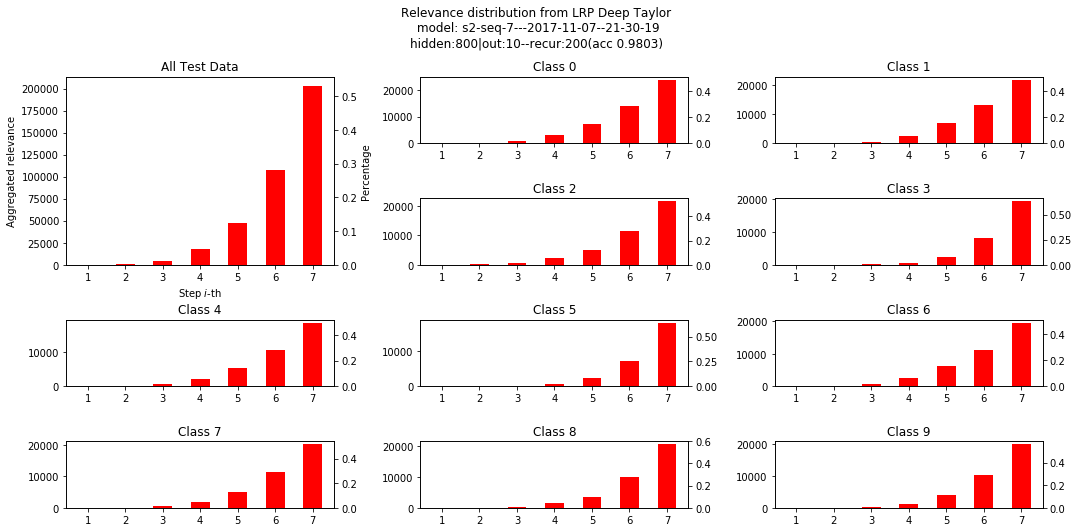

In [77]:
seq_7_s2_model = '../experiment-results/sprint-6/s2-seq-7---2017-11-07--21-30-19'
plot_lrp_relevance_dist_all(seq_7_s2_model)

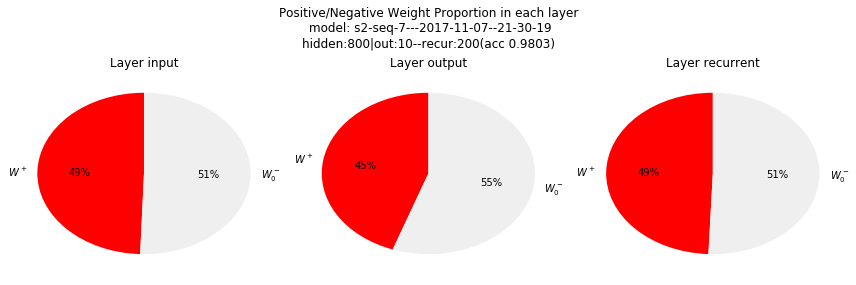

In [86]:
plot_weight_proportion(seq_7_s2_model, show_title=True)

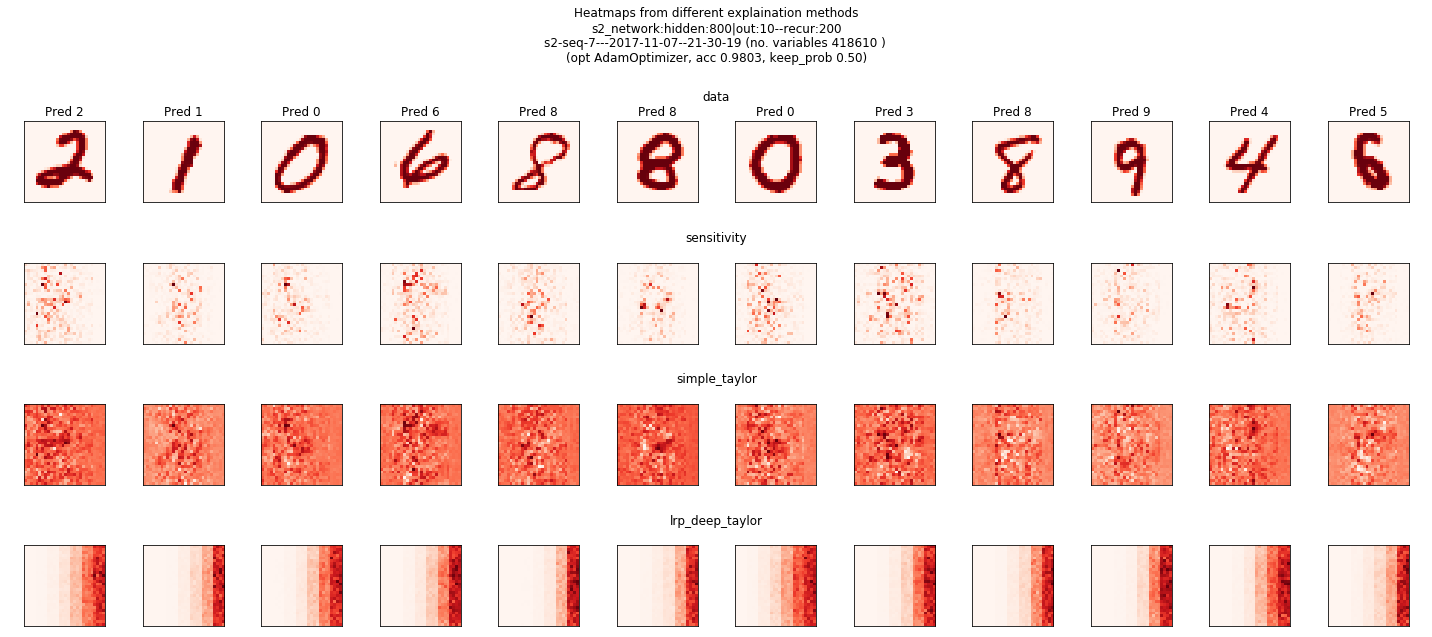

In [79]:
plot_relevance_methods(seq_7_s2_model)

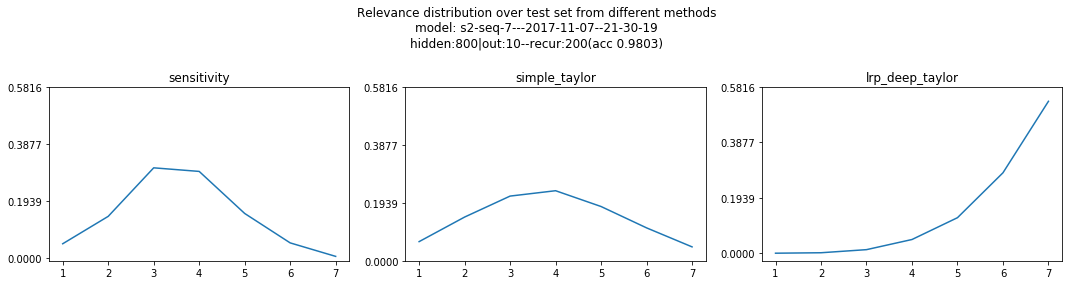

In [84]:
plot_relevance_dist(seq_7_s2_model)

INFO:tensorflow:Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


2017-11-30 16:31:56,681 | INFO : tf_logging.py(info 82) - Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


INFO:tensorflow:Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


2017-11-30 16:32:06,436 | INFO : tf_logging.py(info 82) - Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


INFO:tensorflow:Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


2017-11-30 16:32:08,821 | INFO : tf_logging.py(info 82) - Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


INFO:tensorflow:Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


2017-11-30 16:32:10,721 | INFO : tf_logging.py(info 82) - Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


INFO:tensorflow:Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


2017-11-30 16:32:12,674 | INFO : tf_logging.py(info 82) - Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


INFO:tensorflow:Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


2017-11-30 16:32:14,885 | INFO : tf_logging.py(info 82) - Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


INFO:tensorflow:Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


2017-11-30 16:32:16,837 | INFO : tf_logging.py(info 82) - Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


INFO:tensorflow:Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


2017-11-30 16:32:19,532 | INFO : tf_logging.py(info 82) - Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


INFO:tensorflow:Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


2017-11-30 16:32:21,678 | INFO : tf_logging.py(info 82) - Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


INFO:tensorflow:Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


2017-11-30 16:32:24,598 | INFO : tf_logging.py(info 82) - Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


INFO:tensorflow:Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


2017-11-30 16:32:27,593 | INFO : tf_logging.py(info 82) - Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


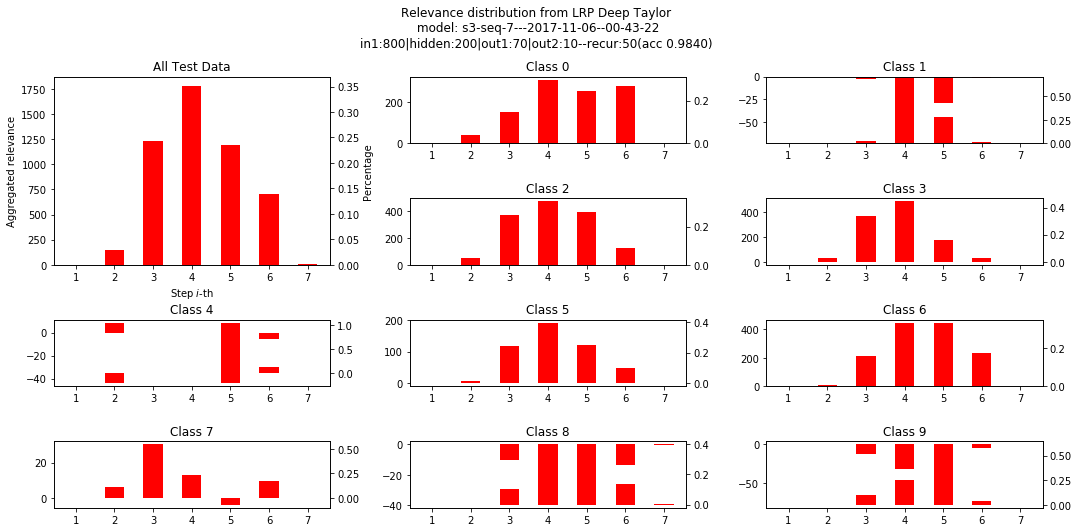

In [21]:
seq_7_s3_model = '../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22'
plot_lrp_relevance_dist_all(seq_7_s3_model)

INFO:tensorflow:Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


2017-11-30 16:32:38,236 | INFO : tf_logging.py(info 82) - Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


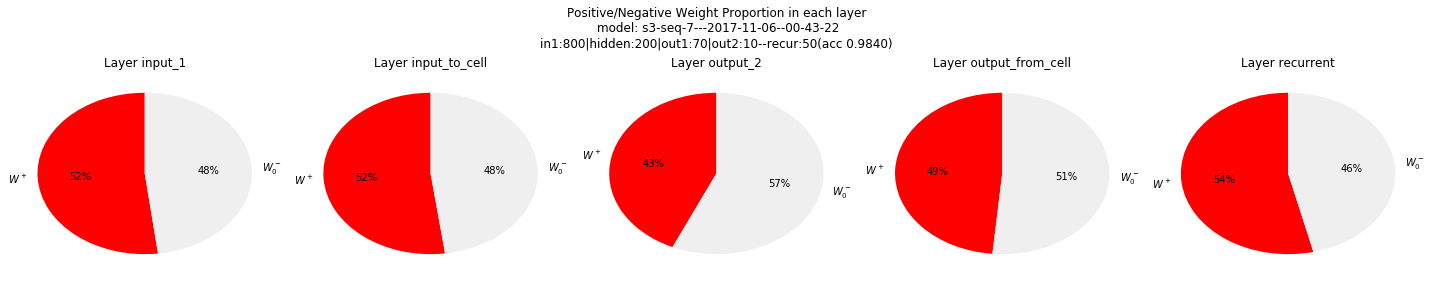

In [22]:
plot_weight_proportion(seq_7_s3_model, show_title=True)

INFO:tensorflow:Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


2017-11-30 16:32:43,562 | INFO : tf_logging.py(info 82) - Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


INFO:tensorflow:Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


2017-11-30 16:32:46,619 | INFO : tf_logging.py(info 82) - Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


INFO:tensorflow:Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


2017-11-30 16:32:49,969 | INFO : tf_logging.py(info 82) - Restoring parameters from ../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22/model.ckpt


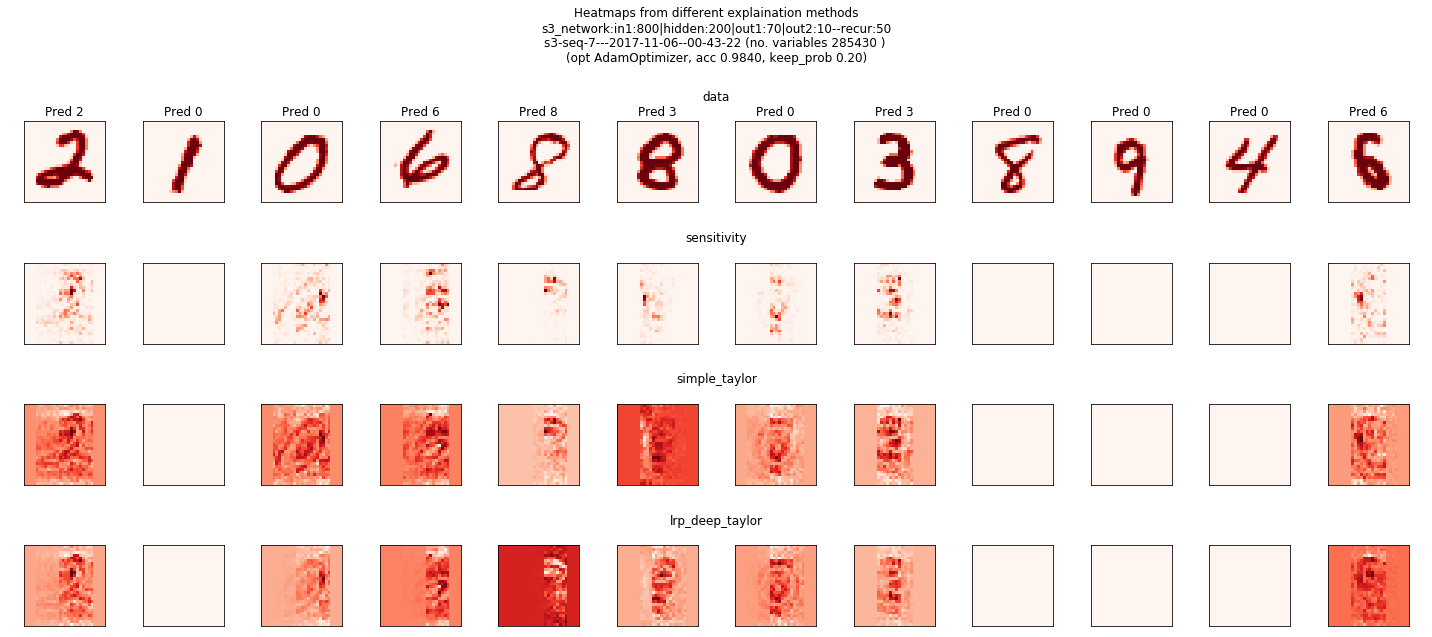

In [23]:
plot_relevance_methods(seq_7_s3_model)

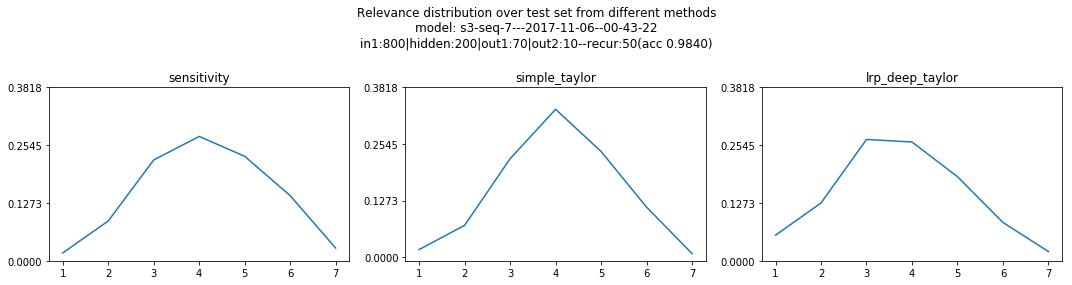

In [83]:
plot_relevance_dist(seq_7_s3_model)

## Seq-14

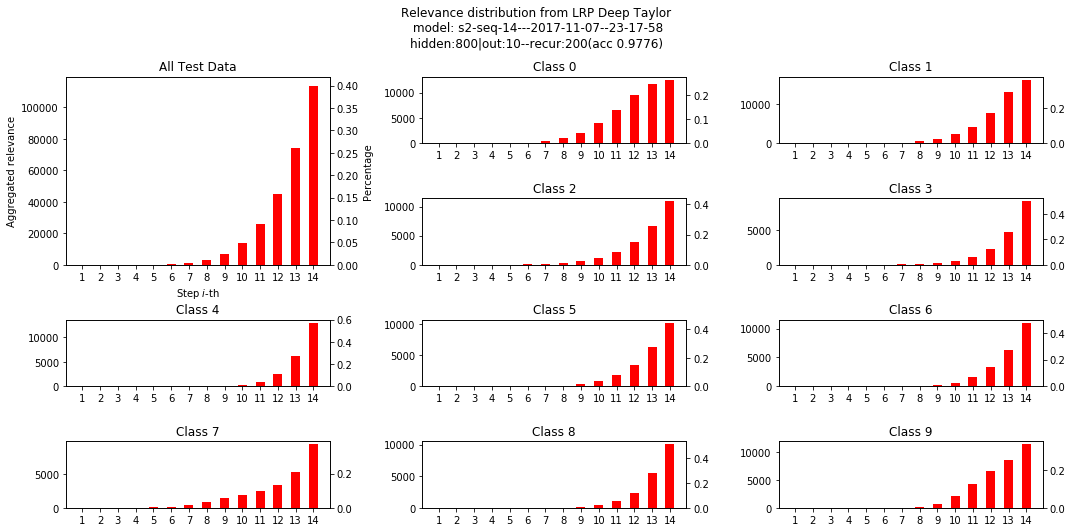

In [87]:
seq_14_s2_model='../experiment-results/sprint-6/s2-seq-14---2017-11-07--23-17-58'
plot_lrp_relevance_dist_all(seq_14_s2_model)

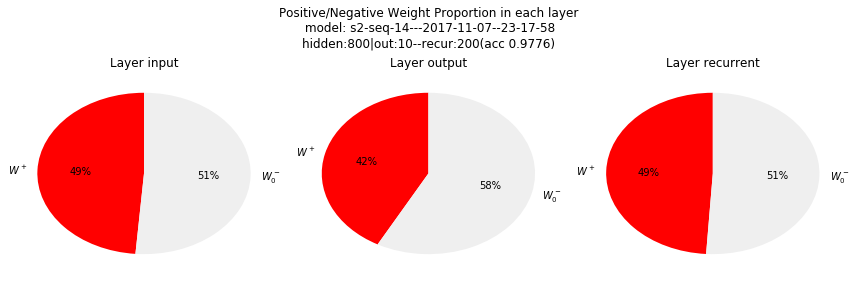

In [88]:
plot_weight_proportion(seq_14_s2_model, show_title=True)

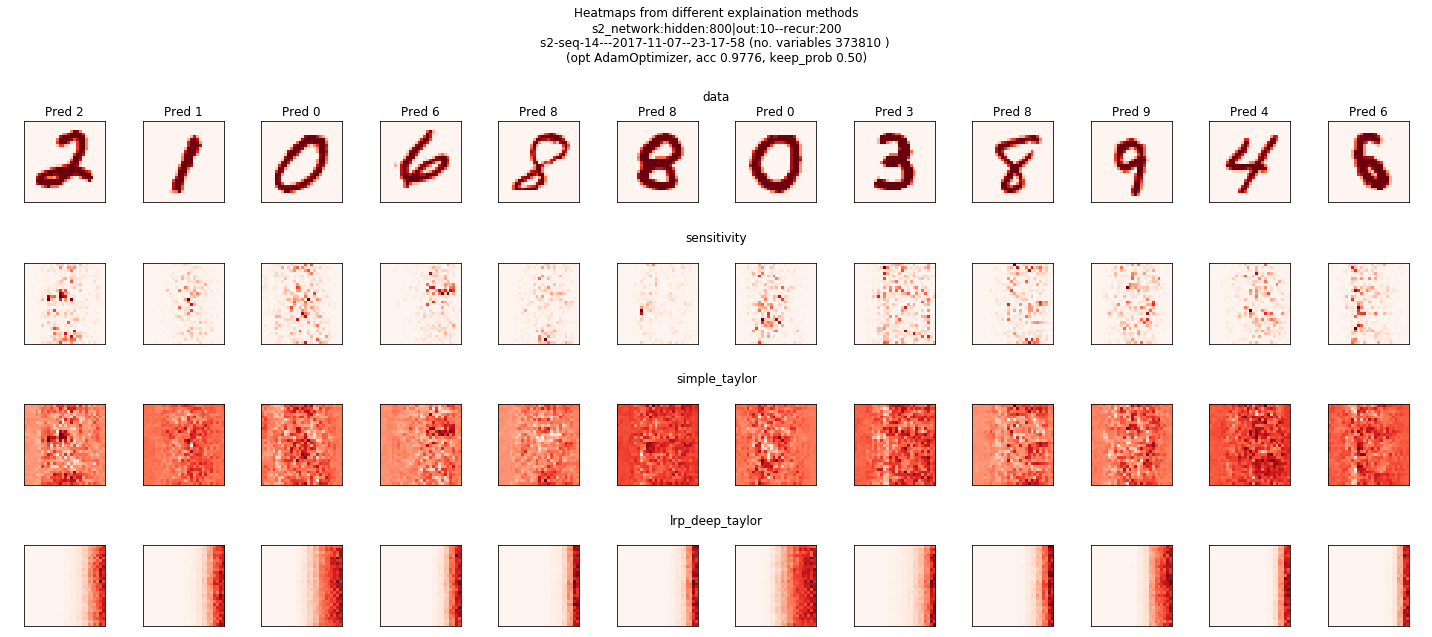

In [89]:
plot_relevance_methods(seq_14_s2_model)

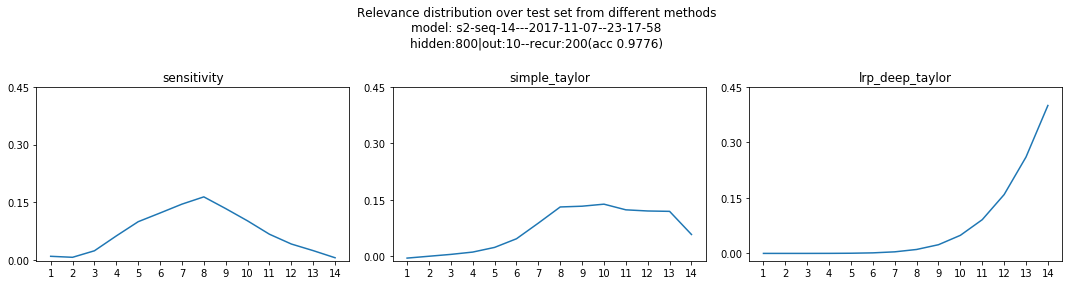

In [90]:
plot_relevance_dist(seq_14_s2_model)

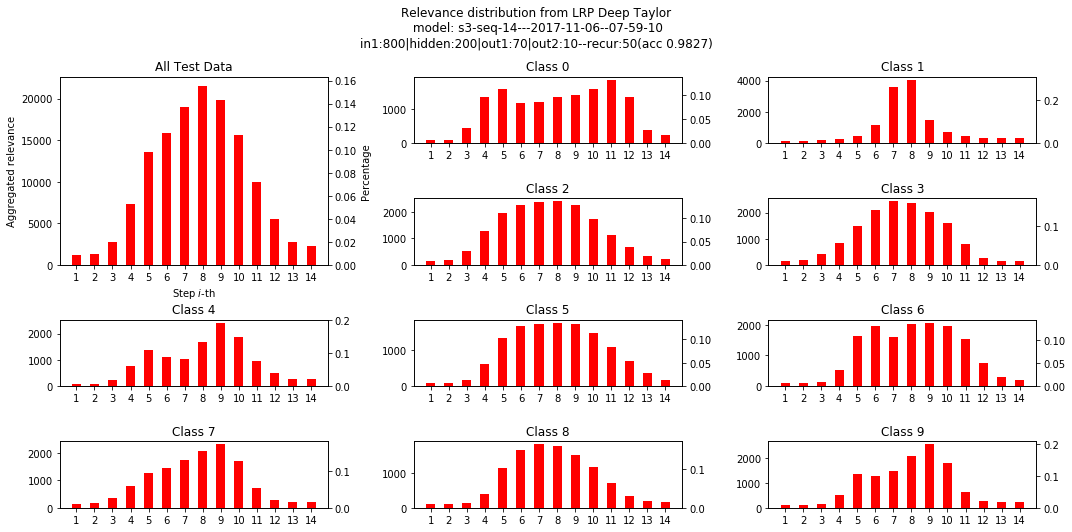

In [91]:
seq_14_s3_model='../experiment-results/sprint-6/s3-seq-14---2017-11-06--07-59-10'
plot_lrp_relevance_dist_all(seq_14_s3_model)

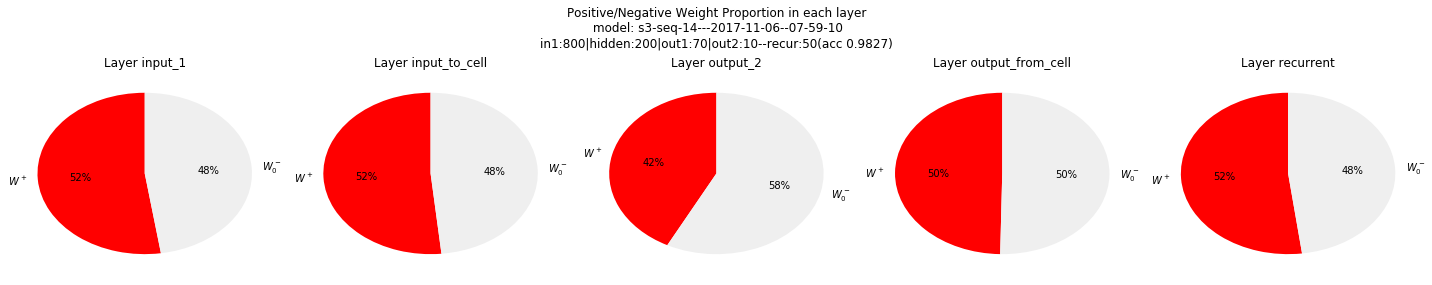

In [92]:
plot_weight_proportion(seq_14_s3_model, show_title=True)

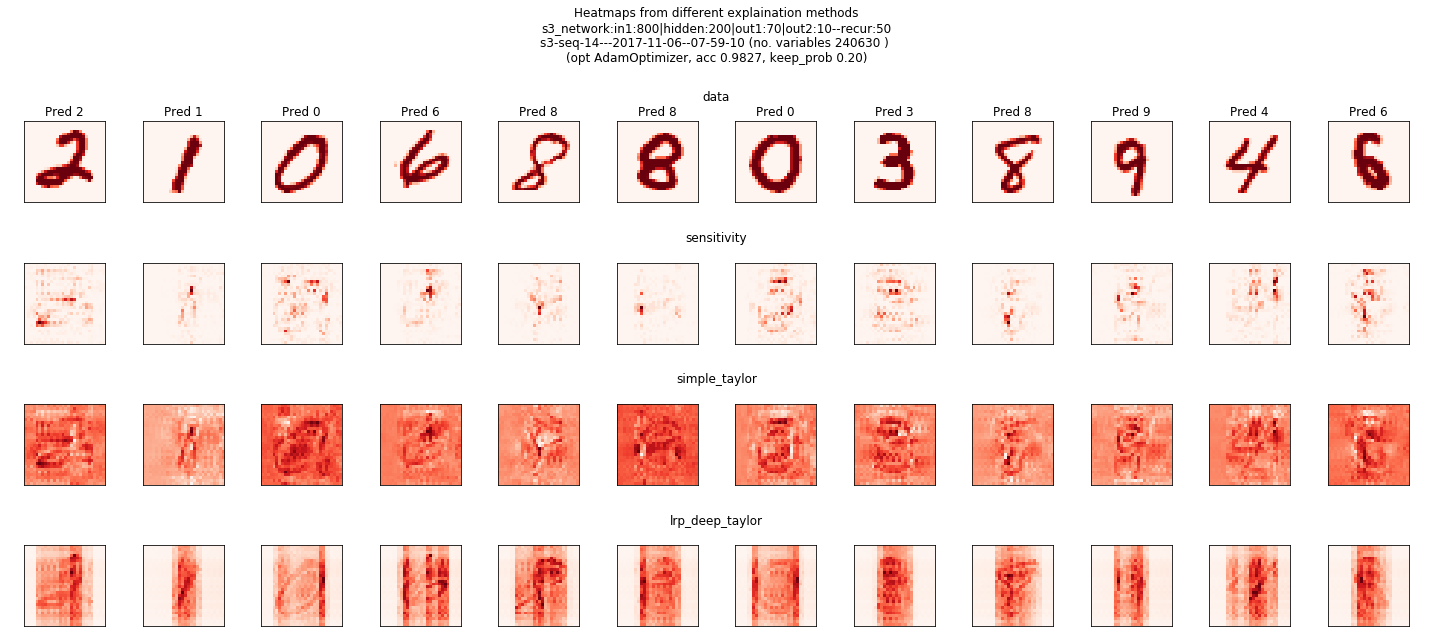

In [93]:
plot_relevance_methods(seq_14_s3_model)

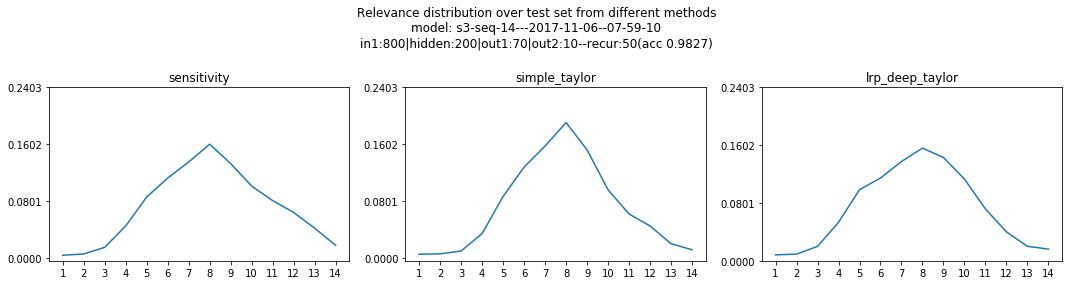

In [94]:
plot_relevance_dist(seq_14_s3_model)

# LRP Factor Rule

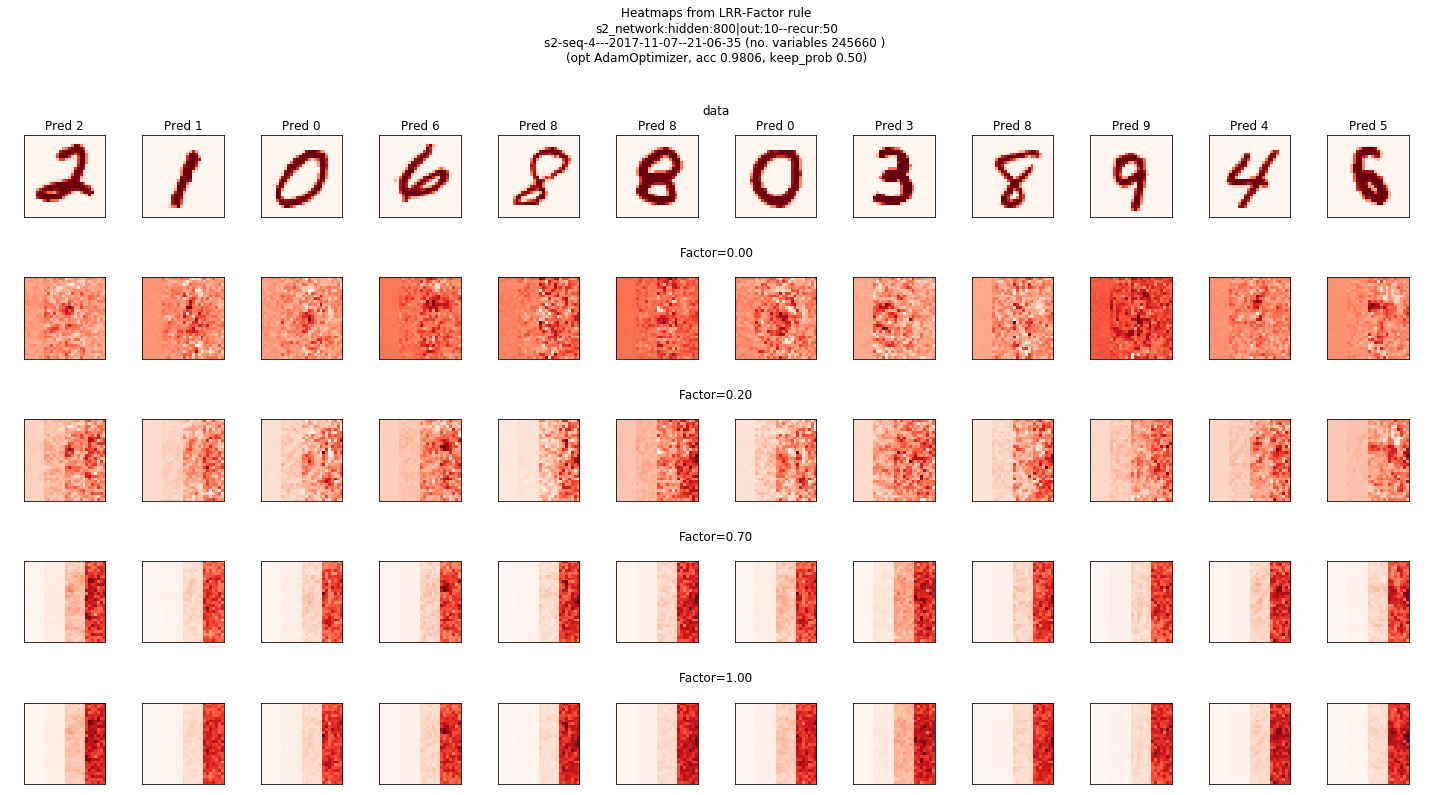

In [113]:
from model import base
import imp
from model.components import lrp
imp.reload(base)
imp.reload(s2_network)
imp.reload(lrp)
imp.reload(s3_network)

def plot_lrp_factor_rules(model_path, data=x_from_tutorial, factors=[0, 0.2, 0.7, 1]):
    model_obj = model_provider.load(model_path)

    total = data.shape[0]
    
    factors = [None] + factors
    total_factors = len(factors)
    
    fig = plt.figure(figsize=(20,2*total_factors))

    outer = gridspec.GridSpec(total_factors, 1)

    pred_heatmaps = dict()
    actual_factors = list(filter(lambda x : x is not None, factors))
    for f in actual_factors:

        pred_heatmaps[f] = model_obj.lrp(data, factor=f)

    for i in range(total_factors):
        inner = gridspec.GridSpecFromSubplotSpec(1, total,
                        subplot_spec=outer[i], wspace=0.1, hspace=0.01)
   
        factor = factors[i]
            
        for j in range(total):
            ax = plt.Subplot(fig, inner[j])
            if factor is not None:
                heatmap = pred_heatmaps[factor][1][j,:,:]
            else:
                heatmap = data[j,:]
                ax.set_title('Pred %d' % pred_heatmaps[actual_factors[0]][0][j])

            ax.imshow(heatmap, cmap="Reds")
            ax.set_xticks([])
            ax.set_yticks([])

            fig.add_subplot(ax)
        
        ax_outer = plt.Subplot(fig, outer[i])
        if factor is not None:
            title = 'Factor=%.2f' % factor
        else:
            title = 'data'
            
        ax_outer.set_title('\n%s\n' % title)

        ax_outer._frameon = False
        ax_outer.xaxis.set_visible(False)
        ax_outer.yaxis.set_visible(False)
        fig.add_subplot(ax_outer)

    plt.suptitle('Heatmaps from LRR-Factor rule\n%s:%s\n%s (no. variables %d ) \n(opt %s, acc %.4f, keep_prob %.2f)' %
                         (
                          model_obj._.architecture_name,
                          model_obj._.architecture,
                          model_obj._.experiment_name,
                          model_obj.dag.no_variables(),
                          model_obj._.optimizer,
                          model_obj._.accuracy,
                          model_obj._.keep_prob
                         ), y = 1.1)
    
    plt.tight_layout()    

    plt.show()
plot_lrp_factor_rules(seq_4_s2_model)

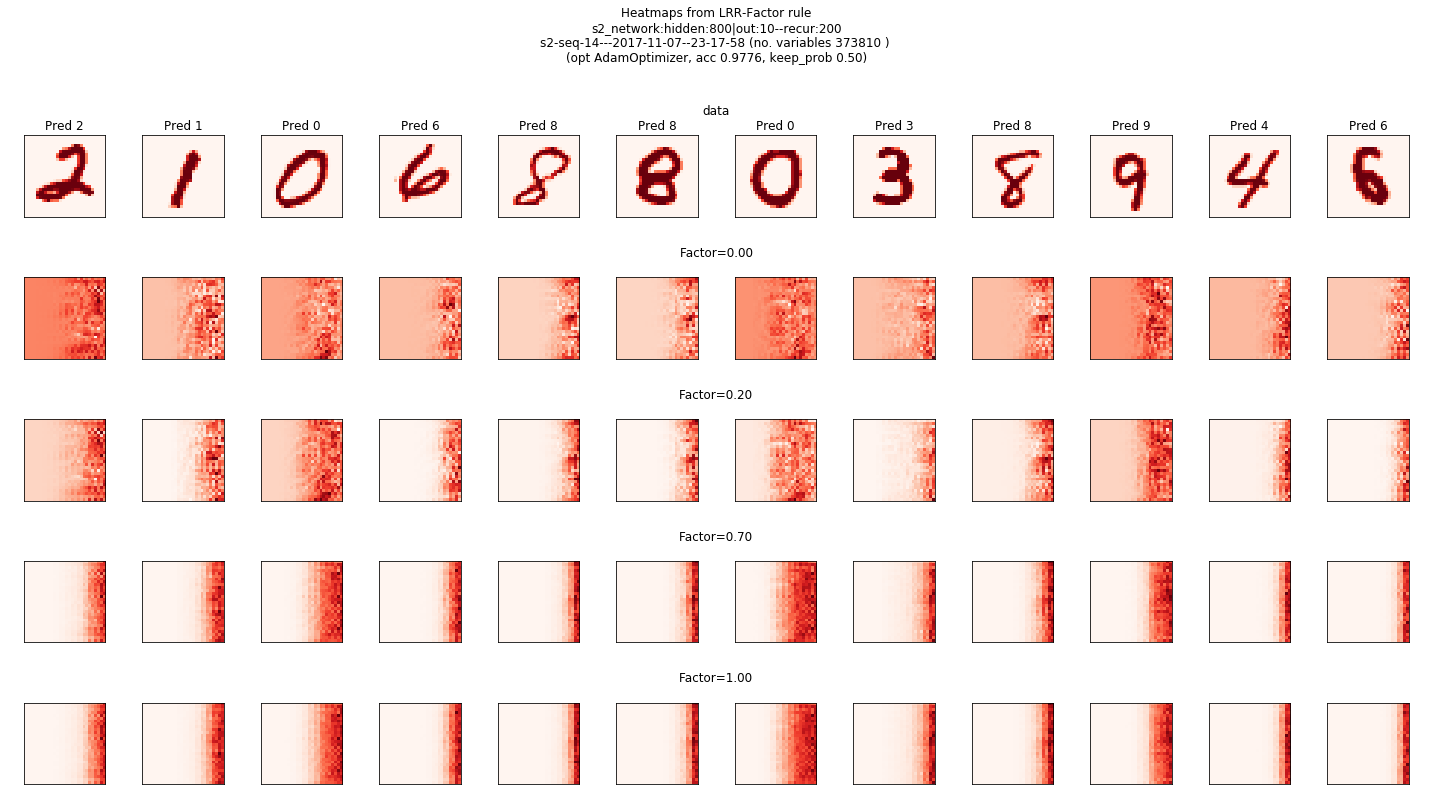

In [115]:
plot_lrp_factor_rules(seq_14_s2_model)

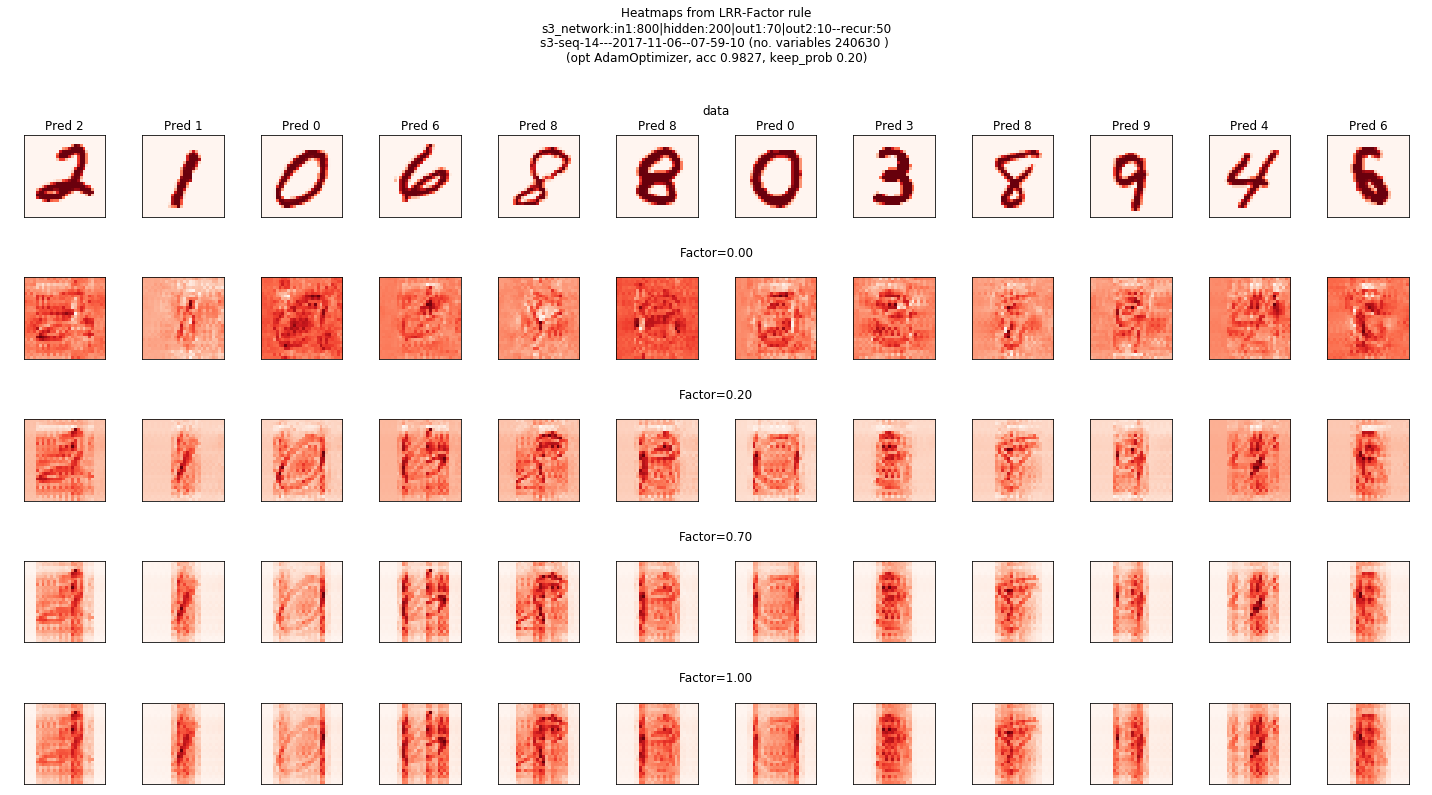

In [114]:
plot_lrp_factor_rules(seq_14_s3_model)

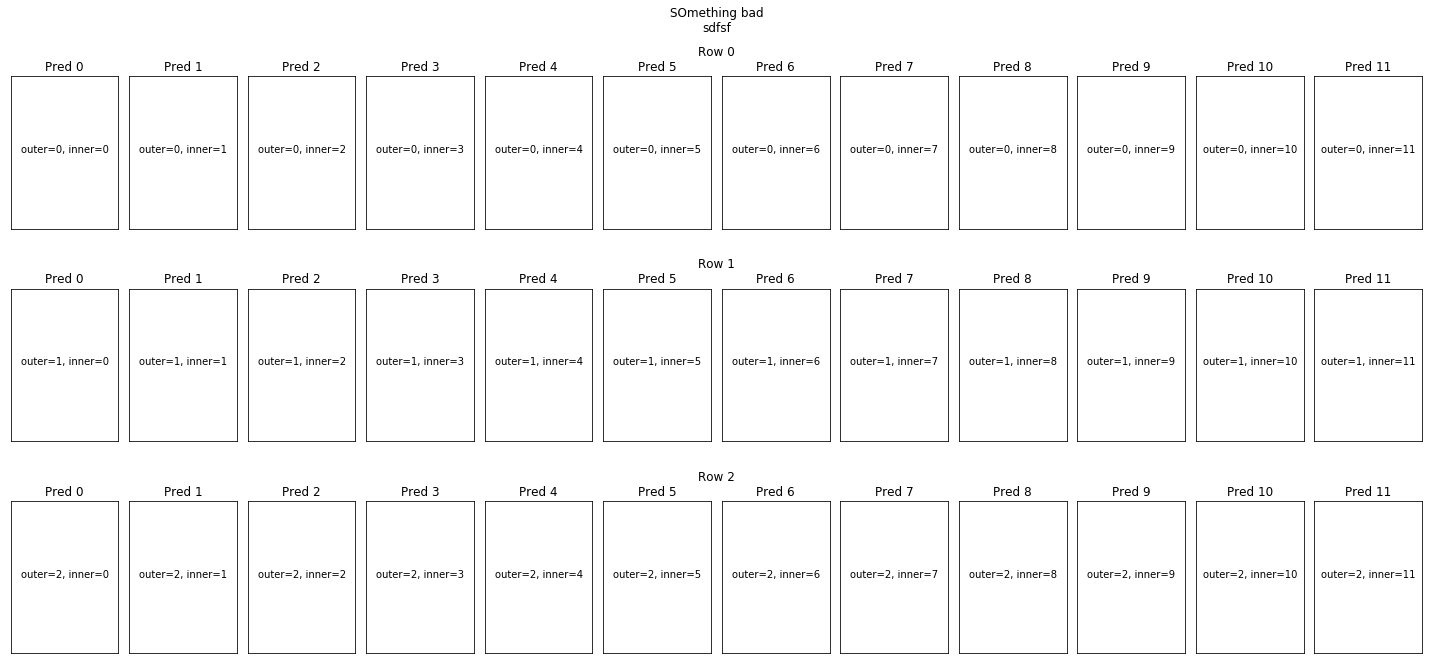

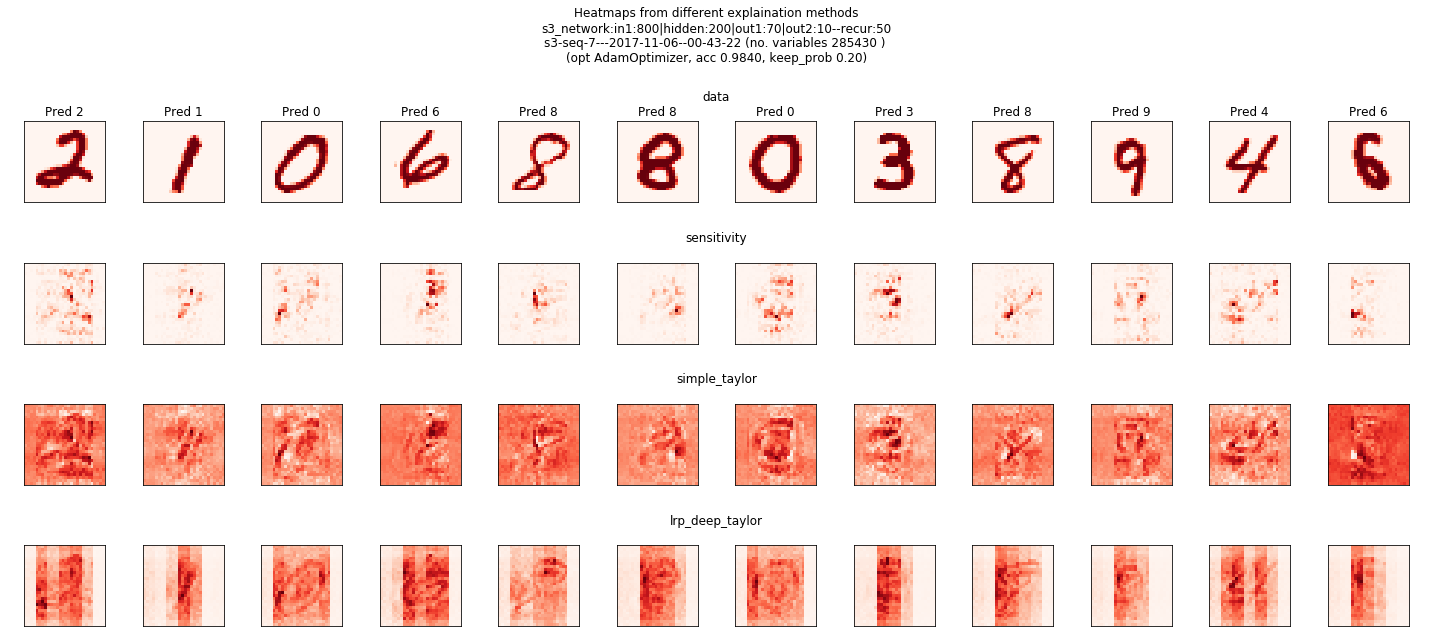

In [38]:
def plot_relevance(model_path, data, methods=['lrp_deep_taylor']):
    model_obj = model_provider.load(model_path)

    total = data.shape[0]
    
    methods = [None] + methods
    total_methods = len(methods)
    
    fig = plt.figure(figsize=(20,2*total_methods))

    outer = gridspec.GridSpec(total_methods, 1)

    pred_heatmaps = dict()
    actual_methods = list(filter(lambda x: x, methods))
    for method in actual_methods:
        pred_heatmaps[method] = getattr(model_obj, 'rel_%s' % method)(data, debug=False)

    for i in range(total_methods):
        inner = gridspec.GridSpecFromSubplotSpec(1, total,
                        subplot_spec=outer[i], wspace=0.1, hspace=0.01)
   
        method = methods[i]
            
        for j in range(total):
            ax = plt.Subplot(fig, inner[j])
            if method is not None:
                heatmap = pred_heatmaps[method][1][j,:,:]
            else:
                heatmap = data[j,:]
                ax.set_title('Pred %d' % pred_heatmaps[actual_methods[0]][0][j])

            ax.imshow(heatmap, cmap="Reds")
            ax.set_xticks([])
            ax.set_yticks([])

            fig.add_subplot(ax)
        
        ax_outer = plt.Subplot(fig, outer[i])
        if method is not None:
            title = method
        else:
            title = 'data'
            
        ax_outer.set_title('\n%s\n' % title)

        ax_outer._frameon = False
        ax_outer.xaxis.set_visible(False)
        ax_outer.yaxis.set_visible(False)
        fig.add_subplot(ax_outer)

    plt.suptitle('Heatmaps from different explaination methods\n%s:%s\n%s (no. variables %d ) \n(opt %s, acc %.4f, keep_prob %.2f)' %
                         (
                          model_obj._.architecture_name,
                          model_obj._.architecture,
                          model_obj._.experiment_name,
                          model_obj.dag.no_variables(),
                          model_obj._.optimizer,
                          model_obj._.accuracy,
                          model_obj._.keep_prob
                         ), y = 1.1)
    
    plt.tight_layout()    
    plt.show()
plot_relevance('../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22',
               x_from_tutorial, methods=['sensitivity', 'simple_taylor', 'lrp_deep_taylor'])

In [12]:
#     plt.show()
    
# plot_weight_proportion('../experiment-results/sprint-6-improve-dropout-ly/s3-seq-4---2017-11-09--21-29-46')

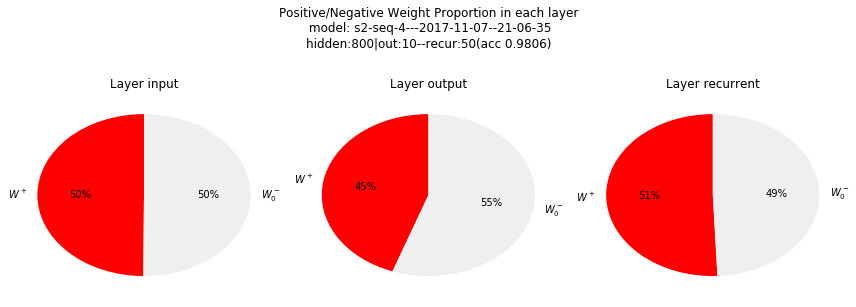

In [44]:
np.sum(weights['input_1'] > 0)

102159

In [45]:
np.sum(weights['input_1'] < 0)

93841

In [40]:
model_obj.dag.layers

{'input_1': <model.components.layer.Layer at 0x117e13da0>,
 'input_to_cell': <model.components.layer.Layer at 0x1508d3390>,
 'output_2': <model.components.layer.Layer at 0x1308ef7b8>,
 'output_from_cell': <model.components.layer.Layer at 0x150378940>,
 'recurrent': <model.components.layer.Layer at 0x118d42cc0>}

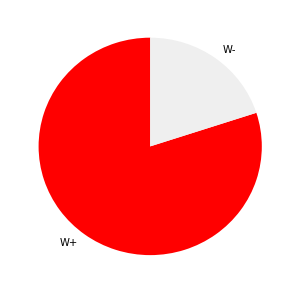

In [31]:
plt.figure(figsize=(5,5))
plt.pie([0.8,0.2], labels=['W+','W-'], startangle=90, colors=['r','#EFEFEF'])
plt.show()

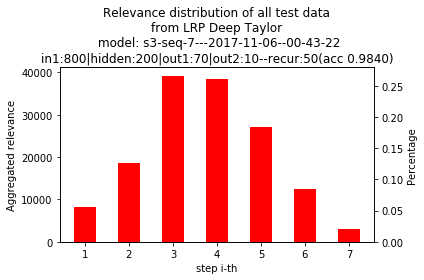

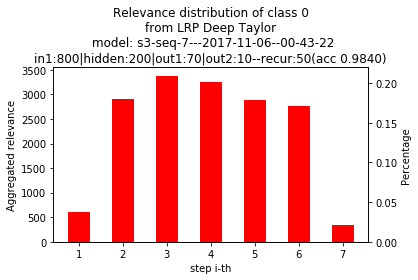

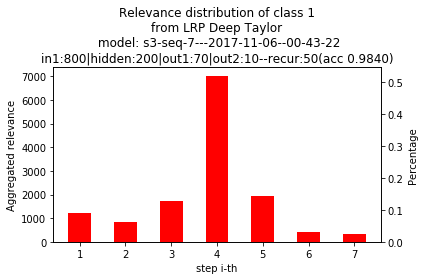

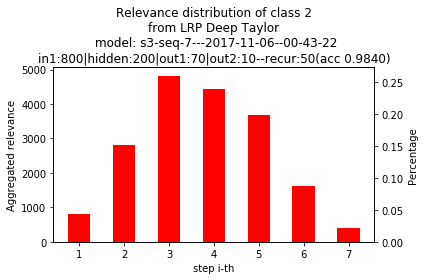

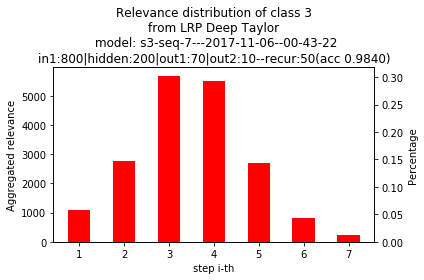

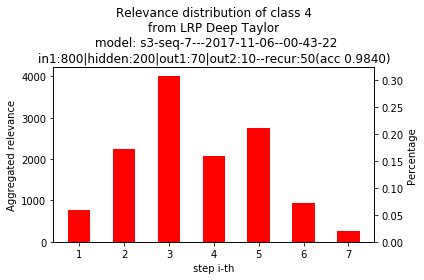

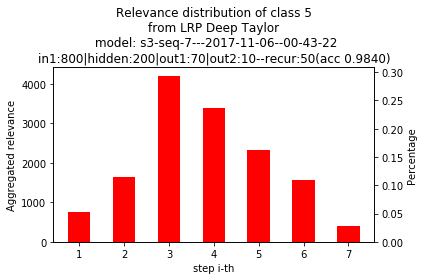

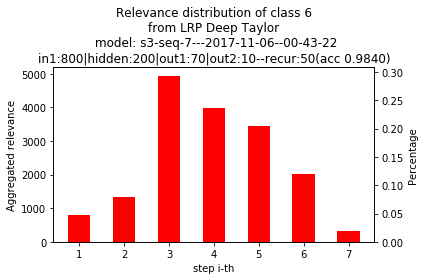

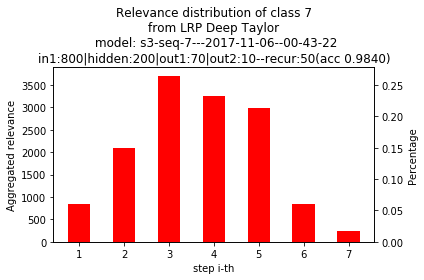

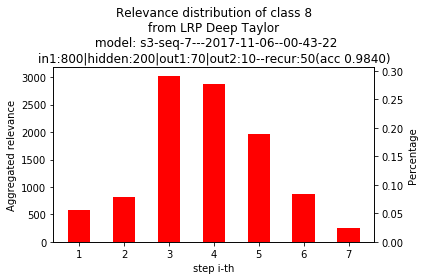

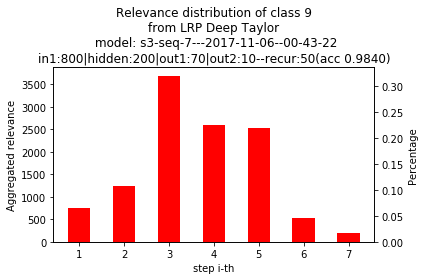

In [82]:
def plot_all_classes(model_path):
    for i in [None] + list(range(0,10)):
        plot_lrp_dt_relevance_distribution(model_path, label=i)
plot_all_classes('../experiment-results/sprint-6/s3-seq-7---2017-11-06--00-43-22')

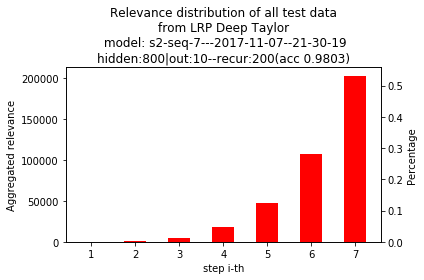

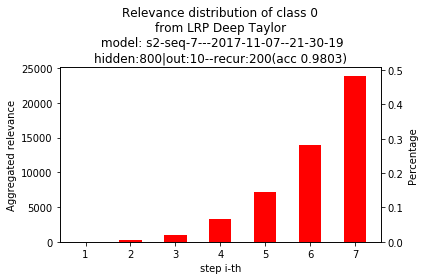

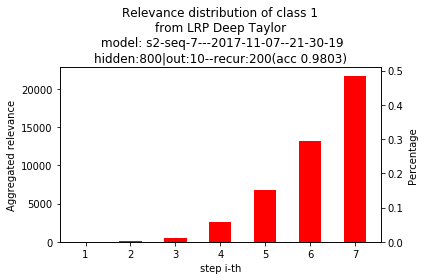

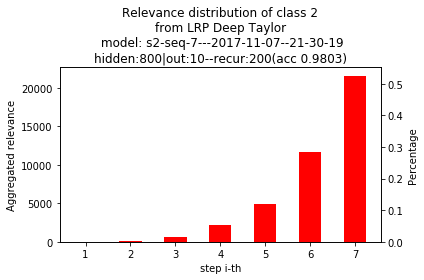

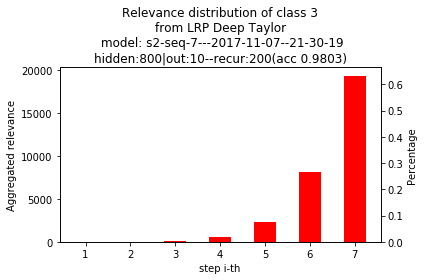

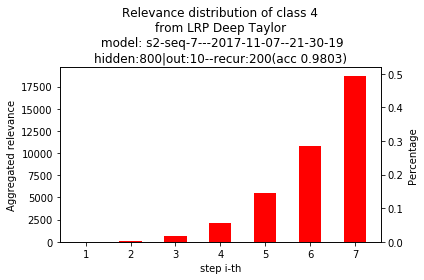

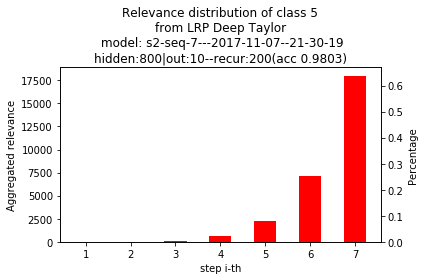

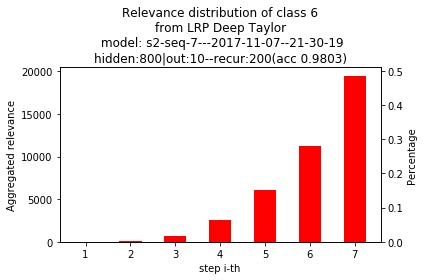

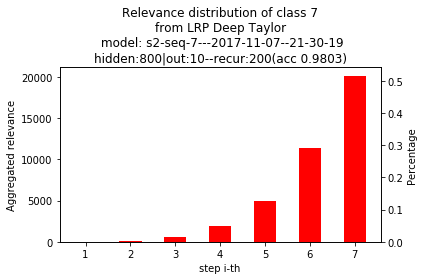

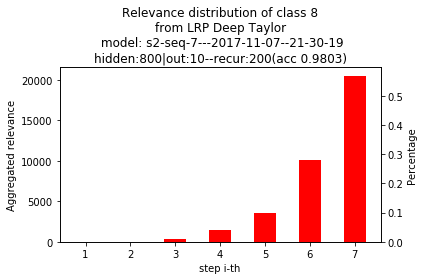

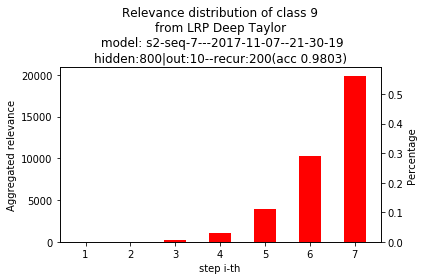

In [83]:
plot_all_classes('')

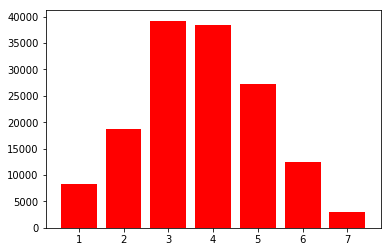

In [26]:
plt.bar(np.arange(7)+1, rel_dist_dt, color='red')
plt.show()

In [130]:
model_obj = model_provider.load('../experiment-results/sprint-6/s3-seq-4---2017-11-07--21-46-02')
with model_obj.get_session() as sess:
    merged_summary_op = tf.summary.merge
    summary_writer = tf.summary.FileWriter('../tf-logs', sess.graph)
    summary_writer.close()

INFO:tensorflow:Restoring parameters from ../experiment-results/sprint-6/s3-seq-4---2017-11-07--21-46-02/model.ckpt


2017-11-16 13:39:56,309 | INFO : tf_logging.py(info 82) - Restoring parameters from ../experiment-results/sprint-6/s3-seq-4---2017-11-07--21-46-02/model.ckpt


In [64]:
model_obj._.column_at_a_time

7

In [65]:
model_obj._

ExperimentArtifact(accuracy=0.9839000105857849, architecture='in1:800|hidden:200|out1:70|out2:10--recur:50', batch=50, column_at_a_time=7, dims=28, epoch=100, experiment_name='s3-seq-4---2017-11-07--21-46-02', lr=0.0001, max_seq_length=28, seq_length=4, path='../experiment-results/sprint-6/s3-seq-4---2017-11-07--21-46-02', architecture_name='s3_network', val_accuracy=0.98224998, keep_prob=0.2, optimizer='AdamOptimizer')

array([  8259.21962578,  18699.10043153,  39225.99083105,  38405.90328113,
        27196.4345498 ,  12387.37202618,   2995.12796159])

In [23]:
a = {'a': 2, 'b':3 }

In [28]:
list(a.keys())[0]

'b'